In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.metric.metric import Metric
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.portfolio_management.portfolio import Portfolio, OptimizedPortfolio
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()

In [6]:
orivault.connect()
a = orivault.retrieve("results")
orivault.disconnect()

In [7]:
valid = a[(a["position_type"]=="long") & (a["selection_type"]!="long_short")].sort_values("pnl",ascending=False)
valid.head(20)

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,rolling_window
18,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20,7857.795634,3.489915,2251.572278,1.109816,0.915397,0.527273,1.017909,3.487586,20
20,ema,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20,5218.902775,2.444101,2135.305624,1.112077,0.913346,0.524909,1.017662,2.441630,20
23,bollinger_upper,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20,3574.180285,3.851456,928.007623,1.107332,0.915663,0.536000,1.018398,3.845804,20
42,roc,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,0.5,2024-12-20,1046.602981,3.310698,316.127626,1.103742,0.917178,0.528545,1.015785,3.294107,20
35,sma_corr,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,0.5,2024-12-20,687.545467,2.743947,250.568011,1.097348,0.921367,0.526364,1.013997,2.722889,20
32,rolling_dollar_volume,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,0.5,2024-12-20,28.194804,4.468945,6.309052,1.054871,0.906201,0.685455,1.008107,3.632575,20
84,ema,WEEK,long,AVERAGE_RETURN,top,equal,coefficient_of_variation,0.5,2024-12-20,14.886394,0.990381,15.030980,1.086900,0.916987,0.510182,1.003673,0.639326,20
107,williams_r,WEEK,long,AVERAGE_RETURN,bottom,equal,coefficient_of_variation,0.5,2024-12-20,12.210927,3.120745,3.912824,1.049354,0.944966,0.579636,1.005473,1.780360,20
3,sma_corr,WEEK,long,STANDARD_DEV,mixed,equal,coefficient_of_variation,0.5,2024-12-20,10.478557,2.144132,4.887087,1.065627,0.940516,0.516545,1.005142,1.064408,20
109,vwap,WEEK,long,AVERAGE_RETURN,bottom,equal,coefficient_of_variation,0.5,2024-12-20,10.442777,4.443588,2.350078,1.066149,0.933001,0.557818,1.007273,2.211878,20


In [8]:
top = valid.head().to_dict("records")[0]
rolling_window = top["rolling_window"]
top

{'ranking_metric': 'sma',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'STANDARD_DEV',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.5,
 'date': Timestamp('2024-12-20 00:00:00'),
 'pnl': 7857.795633874551,
 'coefficient_of_variation': 3.4899148962897732,
 'portfolio_std': 2251.572278231883,
 'average_gain': 1.1098160666634587,
 'average_loss': 0.9153974301174183,
 'win_loss_ratio': 0.5272727272727272,
 'weekly_return': 1.0179090748416941,
 'sharpe_ratio': 3.487585550159361,
 'rolling_window': 20}

In [9]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)	
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4266/4266 [03:45<00:00, 18.95it/s]


In [10]:
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices)
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [11]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [12]:
base_portfolio = Portfolio.from_dict(top)

In [59]:
portfolios = PortfolioSelection.optimize_portfolio(base_portfolio,group_percentages=[0.005])

In [60]:
analysises = []
for portfolio in tqdm(portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:19<00:00,  9.89s/it]


In [61]:
a = pd.DataFrame(analysises)
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
0,0,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.1,1.058711,5.027639,0.210578,1.05916,0.943816,0.503331,1.001872,-20.030534,<financial_common.portfolio_management.portfol...
1,1,sma,WEEK,long,STANDARD_DEV,top,risk,coefficient_of_variation,0.1,0.373045,1.346347,0.277079,1.00027,0.999730,0.503463,1.000002,-17.697686,<financial_common.portfolio_management.portfol...


In [62]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

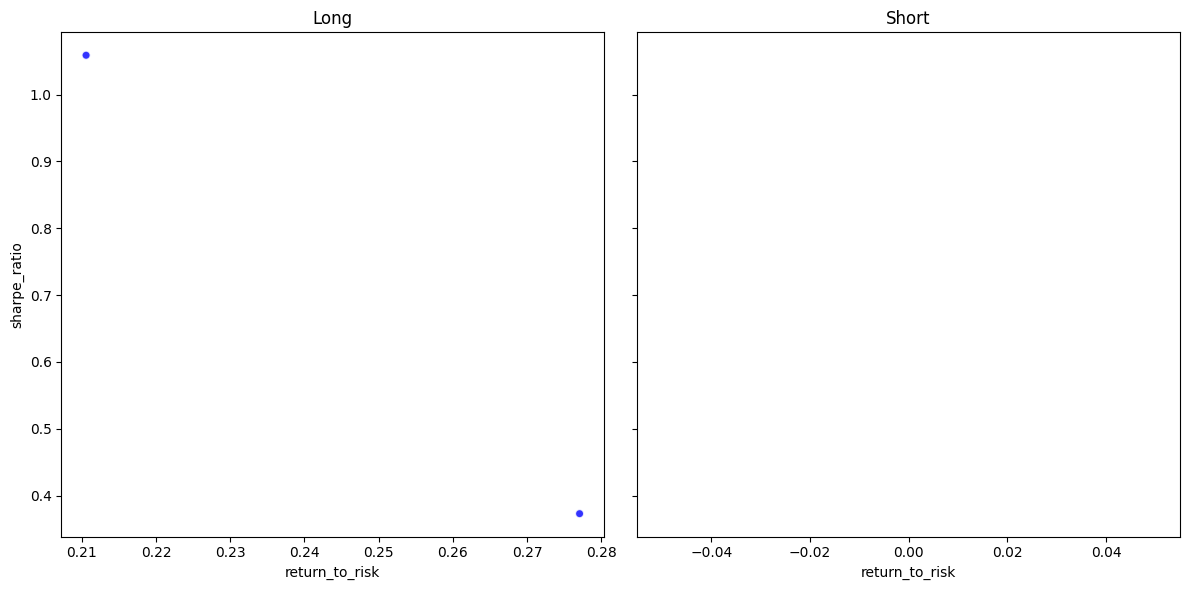

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [64]:
top = a.sort_values("pnl",ascending=False).iloc[0].to_dict()
top["rolling_window"] = rolling_window
top

{'ranking_metric': 'sma',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'STANDARD_DEV',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.1,
 'date': Timestamp('2024-12-20 00:00:00+0000', tz='UTC'),
 'pnl': 1.0587109211590668,
 'coefficient_of_variation': 5.027639119404875,
 'portfolio_std': 0.21057814533123992,
 'average_gain': 1.0591601446855405,
 'average_loss': 0.9438159704764219,
 'win_loss_ratio': 0.503330879993961,
 'weekly_return': 1.0018722551832744,
 'sharpe_ratio': -20.030533572029263,
 'portfolio': <financial_common.portfolio_management.portfolio.OptimizedPortfolio at 0x1bfa1f5f5d0>,
 'color': 'blue',
 'return_to_risk': 5.027639119404875,
 'rolling_window': 20}

In [65]:
orivault.cloud_connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()

In [66]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","name","market_cap"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

In [67]:
portfolio.sort_values("return",ascending=False).head(20)

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week
31,2015-06-18 00:00:00+00:00,1.171067,1.337744,52.587327,1.173939,2015,6,2,25
528,2020-06-11 00:00:00+00:00,1.171067,1.311078,85.121539,1.900220,2020,6,2,24
50,2015-09-02 00:00:00+00:00,1.171067,1.484918,48.148559,1.074850,2015,9,3,36
379,2019-05-29 00:00:00+00:00,1.171067,1.337164,91.760422,2.048424,2019,5,2,22
426,2019-09-26 00:00:00+00:00,1.171067,1.571376,99.934114,2.230890,2019,9,3,39
342,2019-03-05 00:00:00+00:00,1.171067,1.677097,87.611551,1.955806,2019,3,1,10
699,2023-06-01 00:00:00+00:00,1.171067,1.427275,131.808512,2.942442,2023,6,2,22
276,2018-08-16 00:00:00+00:00,1.171067,1.862292,95.132852,2.123709,2018,8,3,33
275,2018-08-14 00:00:00+00:00,1.171067,1.590253,95.033384,2.121488,2018,8,3,33
123,2016-10-20 00:00:00+00:00,1.171067,1.372370,54.479381,1.216176,2016,10,4,42


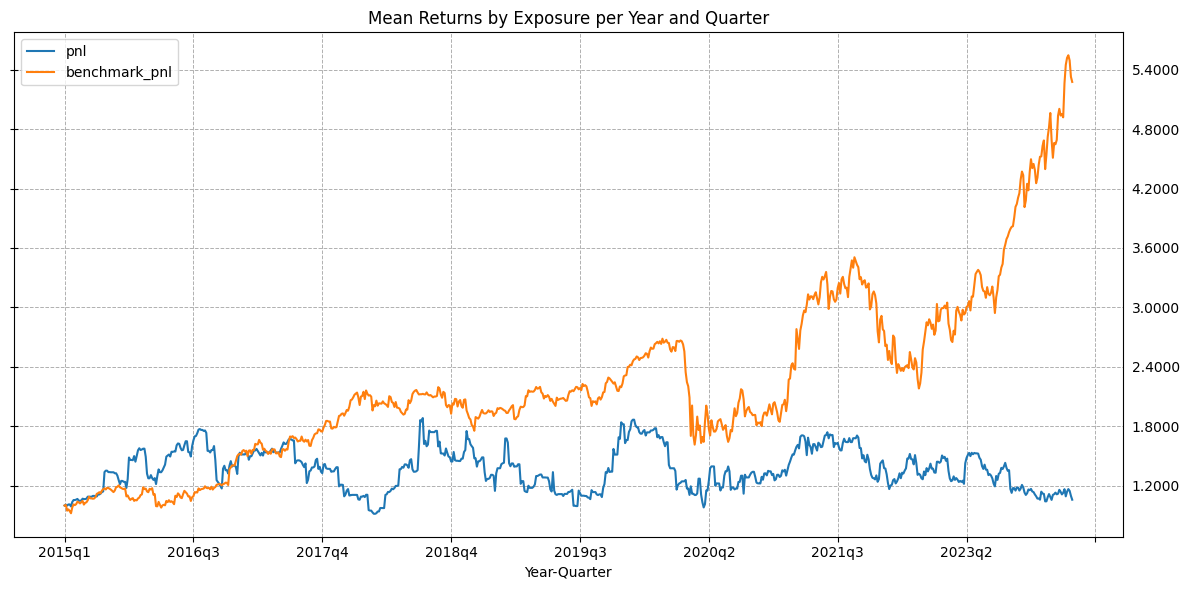

In [68]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [69]:
trades.sort_values(["date","group_percentile"],ascending=False).dropna().head(50).reset_index(drop=True)

,year,week,ticker,date,adjclose,sell_price,standard_dev,sma,risk,group_percentile,...,selection,position_type,weight,unweighted_return,winsorized_return,return,name,market_cap,month,quarter
0,2024,51,FTFT,2024-12-20 00:00:00+00:00,0.270500,0.3014,0.054107,1.430426,0.135656,1.0,...,True,1.0,1,1.114233,1.114233,1.114233,Future FinTech Group Inc.,4.667678e+06,12,4
1,2024,51,GLYC,2024-12-20 00:00:00+00:00,0.239900,0.2339,0.046250,1.325272,0.402666,1.0,...,True,1.0,1,0.974990,0.974990,0.974990,"GlycoMimetics, Inc.",1.683812e+07,12,4
2,2024,51,XAGE,2024-12-20 00:00:00+00:00,0.216800,0.2204,0.045286,1.285547,0.550743,1.0,...,True,1.0,1,1.016605,1.016605,1.016605,"Longevity Health Holdings, Inc. Common Stock",4.945678e+06,12,4
3,2024,51,INTZ,2024-12-20 00:00:00+00:00,0.450000,0.4049,0.051773,1.239196,0.283162,1.0,...,True,1.0,1,0.899778,0.899778,0.899778,Intrusion Inc New,2.506782e+07,12,4
4,2024,51,EKSO,2024-12-20 00:00:00+00:00,0.639900,0.5801,0.044923,1.199718,0.200361,1.0,...,True,1.0,1,0.906548,0.906548,0.906548,"Ekso Bionics Holdings, Inc. Common Stock",1.212458e+07,12,4
5,2024,51,SCLX,2024-12-20 00:00:00+00:00,0.504500,0.4475,0.049983,1.189153,0.283921,1.0,...,True,1.0,1,0.887017,0.887017,0.887017,Scilex Holding Company Common Stock,2.319349e+07,12,4
6,2024,51,SBEV,2024-12-20 00:00:00+00:00,0.152200,0.1496,0.018457,1.188726,0.295111,1.0,...,True,1.0,1,0.982917,0.982917,0.982917,"Splash Beverage Group, Inc.",1.112850e+07,12,4
7,2024,51,YCBD,2024-12-20 00:00:00+00:00,0.340000,0.3600,0.034580,1.180796,0.095477,1.0,...,True,1.0,1,1.058824,1.058824,1.058824,"cbdMD, Inc. Common Stock",1.646499e+06,12,4
8,2024,51,GRYP,2024-12-20 00:00:00+00:00,0.508900,0.4464,0.048181,1.172656,0.169212,1.0,...,True,1.0,1,0.877186,0.877186,0.877186,"Gryphon Digital Mining, Inc Common Stock",2.042933e+07,12,4
9,2024,51,SCWO,2024-12-20 00:00:00+00:00,0.813100,0.7452,0.048947,1.144457,0.216976,1.0,...,True,1.0,1,0.916492,0.916492,0.916492,374Water Inc. Common Stock,4.048148e+07,12,4
